# From Tweets to Networks

The goal of this tutorial is to break-down a dataframe full of tweets, into a network.
We will then visualize this network. 
The overall steps are:
- Load the dataframe.
- Filter on rows that contain interactions (i.e. retweet events).
- Augment the data (i.e. including sentiment).
- Reducing the data frame (if memory is an issue, you can do this first).
- Generating an edgelist, then use it to generate a network object. 
- Visualize using networkx and netwulf

### We will use netwulf
#### pip install netwulf
#### https://netwulf.readthedocs.io/en/latest/about.html

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import nltk

In [2]:
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/herbert/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
df = pd.read_pickle("Raw_Tweets.pkl") # Load your tweets
df.head()

,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid
12221,1221208309728006145,418859255,Sat Jan 25 23:08:44 +0000 2020,en,"RT @DepSecHargan: Every year in the US, 34,800...",retweeted_tweet_without_comment,638,1837,17778,[920035992073064450],9.200360e+17,1.221208e+18,NaN,NaN,NaN
28315,1221213073652043776,14499829,Sat Jan 25 23:27:40 +0000 2020,en,WHO’s risk assessment of the new #coronavirus ...,original,1743,5196950,46697,[],NaN,NaN,NaN,NaN,NaN
6092,1222281847163576321,1135486501,Tue Jan 28 22:14:35 +0000 2020,en,#FYI: 50 million are under travel restrictions...,original,950,27025,11145,[9624742],NaN,NaN,NaN,NaN,NaN
13618,1222289121118511104,117793973,Tue Jan 28 22:43:30 +0000 2020,en,What should I do if I have traveled to China a...,original,1236,5860,4578,[],NaN,NaN,NaN,NaN,NaN
19205,1222285279047843843,1465196934,Tue Jan 28 22:28:14 +0000 2020,en,Disease outbreaks can result in misinformation...,original,1946,3581,4636,[],NaN,NaN,NaN,NaN,NaN


In [4]:
df.tweet_type.value_counts()

original                           26275
retweeted_tweet_without_comment    19923
reply                               7292
quoted_tweet                        6397
Name: tweet_type, dtype: int64

### Short-hand Pandas Filters
#### We only want retweets and quoted tweets. Thus, we filter on these tweet types.

In [7]:
## | is short-hand for OR ; & is short-hand for AND
df = df[(df.tweet_type == "retweeted_tweet_without_comment") | (df.tweet_type == "quoted_tweet")]
df

,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid
12221,1221208309728006145,418859255,Sat Jan 25 23:08:44 +0000 2020,en,"RT @DepSecHargan: Every year in the US, 34,800...",retweeted_tweet_without_comment,638,1837,17778,[920035992073064450],9.200360e+17,1.221208e+18,NaN,NaN,NaN
25575,1222280171501256706,20467163,Tue Jan 28 22:07:56 +0000 2020,en,RT @RCCallihan: The declaration of a public he...,retweeted_tweet_without_comment,10261,30106,2762,"[1697808410, 146569971]",1.697808e+09,1.222247e+18,NaN,NaN,NaN
28489,1222283902724820995,426033838,Tue Jan 28 22:22:46 +0000 2020,en,RT @DepSecHargan: Start the #NewYear off right...,retweeted_tweet_without_comment,625,1823,22314,"[920035992073064450, 146569971]",9.200360e+17,1.222239e+18,NaN,NaN,NaN
28496,1222283757119590405,426033838,Tue Jan 28 22:22:11 +0000 2020,en,RT @CDCFlu: Elevated #flu activity is expected...,retweeted_tweet_without_comment,625,1823,22314,[16616061],1.661606e+07,1.222194e+18,NaN,NaN,NaN
12992,1220696703667326976,426033838,Fri Jan 24 13:15:48 +0000 2020,en,RT @CDCemergency: Is it a cold or flu? What’s ...,retweeted_tweet_without_comment,625,1822,22325,[19658936],1.965894e+07,1.220488e+18,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178123,1311697178453254145,13218102,Thu Oct 01 15:59:12 +0000 2020,en,RT @TexasDSHS: Today is #TexasFluDay! A yearly...,retweeted_tweet_without_comment,12181,290055,40056,[68412042],6.841204e+07,1.311671e+18,NaN,NaN,NaN
71249,1320008044714098688,2987671552,Sat Oct 24 14:23:37 +0000 2020,en,"RT @MDHealthDept: Today, @MDHealthDept reports...",retweeted_tweet_without_comment,998,206890,9632,"[44961877, 44961877]",4.496188e+07,1.320005e+18,NaN,NaN,NaN
111383,1320011408311001090,2891165960,Sat Oct 24 14:36:59 +0000 2020,en,"RT @unmc: .@HHSGov Deputy Secretary, Eric D. H...",retweeted_tweet_without_comment,1212,32893,8014,"[16151917, 44783853]",1.615192e+07,1.320011e+18,NaN,NaN,NaN
159487,1320015440249225218,44783853,Sat Oct 24 14:53:00 +0000 2020,en,RT @CDCgov: Today is a good day to talk with y...,retweeted_tweet_without_comment,396,1013652,22511,[146569971],1.465700e+08,1.318949e+18,NaN,NaN,NaN


In [6]:
df[(df.tweet_type == "retweeted_tweet_without_comment") & (df.tweet_type == "quoted_tweet")]
## Why is it empty?

,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid


In [8]:
def get_user2(r):
    if r.tweet_type == "retweeted_tweet_without_comment":
        return np.int64(r.rt_userid)
    elif r.tweet_type == "quoted_tweet":
        return np.int64(r.qtd_userid)
    else:
        return np.nan
    
df["user2"] = df.apply(lambda r: get_user2(r), axis = 1)

In [9]:
sent_analyzer = SentimentIntensityAnalyzer()
# sent_analyzer.polarity_scores(df.text.iloc[0])

{'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'compound': -0.6597}

In [10]:
%%time
df["vaderSent"] = df.text.apply(lambda x: sent_analyzer.polarity_scores(x)["compound"])

CPU times: user 4.82 s, sys: 13.6 ms, total: 4.84 s
Wall time: 4.84 s


In [11]:
sub_cols = ["userid", "user2", "vaderSent"]
df = df[sub_cols]
df = df.rename(columns = {"userid":"user1"})

In [12]:
df.to_pickle("edgelist.pkl")

### Now that you have an edge list, the goal is to process it and explore it as a network

In [13]:
EL =  pd.read_pickle("edge_list_final2.pkl")

In [14]:
EL

,user1,user2,text,vaderSent
26,426033838,146569971,RT @CDCgov: The first human infection with new...,0.0000
150,418859255,146569971,"RT @CDCgov: After being diagnosed at age 41, C...",0.4939
146,418859255,146569971,RT @CDCgov: New CDC study: transgender women d...,0.0000
140,418859255,146569971,RT @CDCgov: While limited person-to-person spr...,-0.2263
134,418859255,146569971,RT @CDCgov: CDC has been proactively preparing...,0.0000
...,...,...,...,...
434,78445977,78445977,"Virginians, you have one hour left to vote in ...",0.0000
14339,35239459,14499829,"RT @WHO: This #Halloween, let's spook #COVID19...",0.4574
51918,2953974395,5558312,"During #COVID19, I have been in continuous com...",0.6369
51918,2953974395,1209417007,"During #COVID19, I have been in continuous com...",0.6369


In [15]:
G = nx.Graph() # Creates a graph object
G.add_edges_from( EL[["user1","user2"]].values ) # Adds edges (and hence nodes from the edgelist)

CC_nodes = list( nx.connected_components(G) )[0] # Generates a list of connected components, extracts the largest
GG = nx.subgraph(G, CC_nodes) # Creates the subgraph of the largest CC

In [16]:
EL[["user1","user2"]].values

array([[ 426033838,  146569971],
       [ 418859255,  146569971],
       [ 418859255,  146569971],
       ...,
       [2953974395,    5558312],
       [2953974395, 1209417007],
       [  18023868,   23711785]])

## Original Visaulization |  Networkx

In [17]:
%%time
pos = nx.spring_layout(GG)

CPU times: user 355 ms, sys: 12.6 ms, total: 367 ms
Wall time: 366 ms


Text(0.5, 1.0, 'This is very ugly')

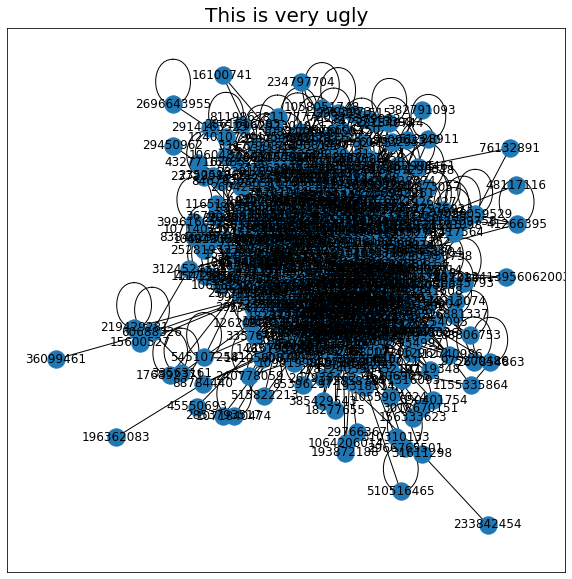

In [18]:
plt.figure(figsize=(10,10))
nx.draw_networkx(GG, pos)
plt.title("This is very ugly", fontsize= 20)

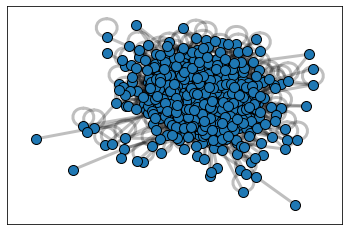

In [19]:
nx.draw_networkx_edges(GG, pos, alpha=0.25, width=3)
nx.draw_networkx_nodes(GG, pos, node_size=100).set_edgecolor('black')

## Netwulf Visualization

In [20]:
from netwulf import visualize
import netwulf as nw

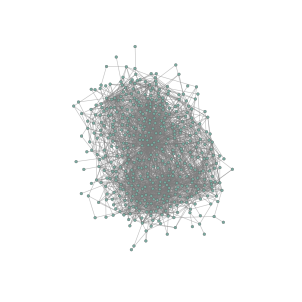

In [21]:
stylized_network, config = visualize(GG,)

In [22]:
U = pd.read_csv("UserStats.csv")

In [23]:
def determine_color(r):
    if r.NodeType == "HealthAgency":
        return "gold"
    elif r.NodeType == "Politician":
        if r.Partyaff == 1:
            return "firebrick"
        elif r.Partyaff == 2:
            return "royalblue"
        else:
            return "grey"
U[ "PlotColor" ] = U.apply(determine_color, axis = 1)

In [24]:
id2color = dict(zip(U.userid.values, U.PlotColor.values))
for k, v in GG.nodes(data=True):
    v["group"] = id2color[k]

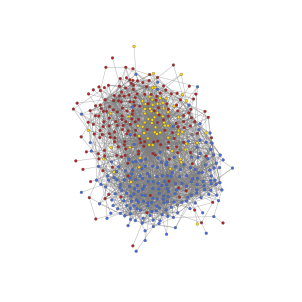

In [25]:
stylized_network, config = visualize(GG,port=2000)

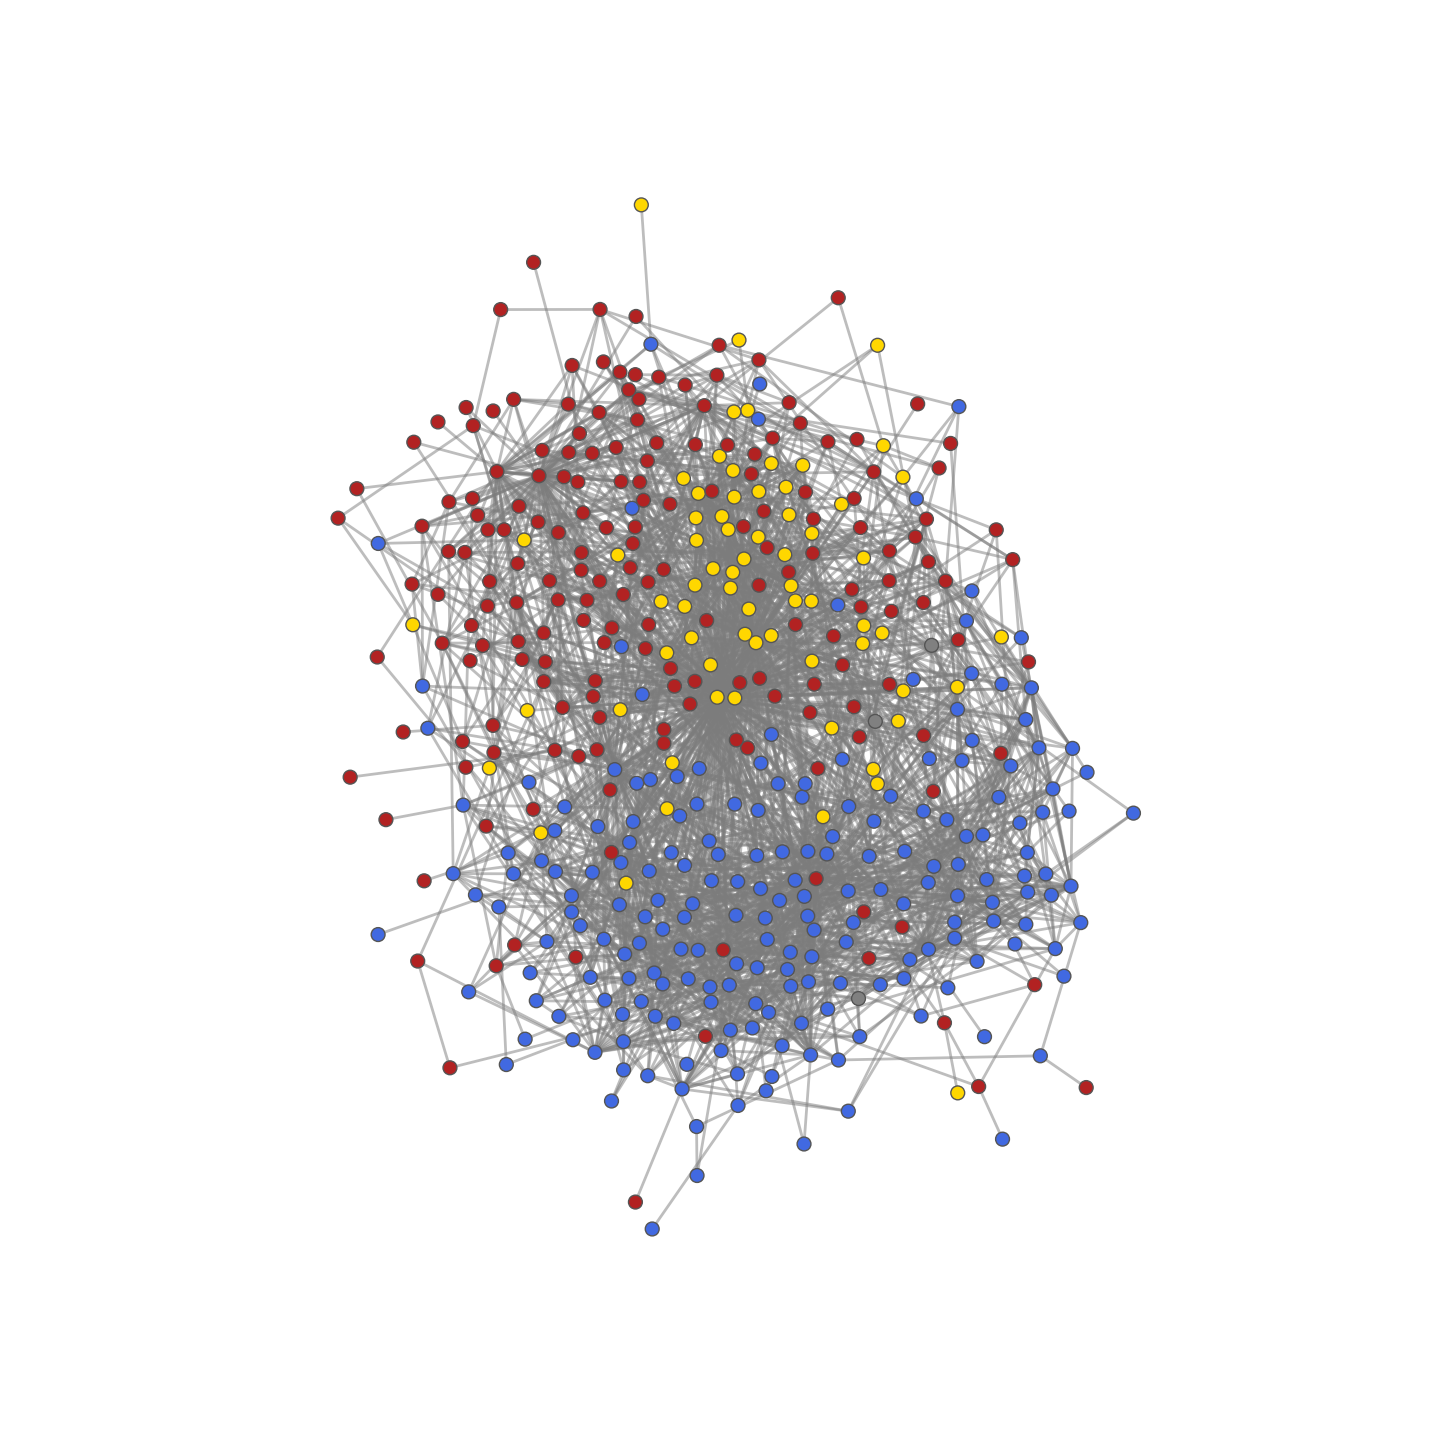

In [26]:
fig, ax = nw.draw_netwulf(stylized_network,figsize=20)
box = dict(facecolor='yellow', alpha=0.8, boxstyle='square') 